Nurul Fadilah 2117051098

File ini berisi hasil eksekusi baseline model (model dasar) dengan parameter default, serta hasil hyperparameter tuning dalam menentukan parameter terbaik. File ini bertujuan untuk mengeksplorasi pengaruh berbagai hyperparameter terhadap kinerja model hybrid CNN-SVM untuk klasifikasi gambar Kupu-Kupu.

**Parameter default:**

 * batch size -> 32
 * image size -> 224x224
 * proporsi data -> 70:15:15
 * kernel -> linear
 * C -> 1.0

## **Baseline Model**

### **Data Preparation**

**Import library**

In [2]:
import random
import os
import numpy as np
import joblib
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import time
import tracemalloc
from sklearn.svm import SVC
from tensorflow import keras
from datetime import datetime
from google.colab import drive
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dropout, Dense, BatchNormalization
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

**Inisialisasi seed**

In [3]:
# setting seed agar mendapat hasil akurasi yang lebih konsisten
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

**Menghubungkan Google Colab dengan Dataset di Goole Drive**

In [4]:
drive.mount("/content/drive")
data_dir = "/content/drive/MyDrive/DeepL/Dataset"

Mounted at /content/drive


**Menghubungkan filepath untuk menyimpan model**

In [5]:
# Definisikan path untuk menyimpan model CNN
checkpoint_dir = '/content/drive/MyDrive/DeepL/Hasil'

# Fungsi untuk menyimpan model CNN
def save_keras_model(model, model_name, test_accuracy):
    timestamp = datetime.now().strftime("%Y%m%d")
    checkpoint_name = f"{model_name}_acc_{test_accuracy:.2f}_{timestamp}.h5"
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)
    model.save(checkpoint_path)
    print(f"Model disimpan di {checkpoint_path}")

In [6]:
# Definisikan path untuk menyimpan model SVM
checkpoint_dir = '/content/drive/MyDrive/DeepL/Hasil'

# Fungsi untuk menyimpan model SVM
def save_model_checkpoint(svm_model, model_name, test_accuracy):
    timestamp = datetime.now().strftime("%Y%m%d")
    checkpoint_name = f"{model_name}_acc_{test_accuracy:.2f}_{timestamp}.joblib"
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)
    joblib.dump(svm_model, checkpoint_path)
    print(f"Model disimpan di {checkpoint_path}")

**Inisialisasi parameter default**

In [7]:
# inisialisasi batch size dan image size (height & weight)
batch_size = 32
img_height = 224
img_width = 224

**Data preparation**

In [8]:
# Muat dataset dari directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Tampilkan semua kelas dari dataset
class_names = dataset.class_names
print("Nama Kelas pada Dataset: ", class_names)

Found 710 files belonging to 9 classes.
Nama Kelas pada Dataset:  ['kupu_batik_cap', 'kupu_harimau_kuning', 'kupu_harimau_kuning_hijau', 'kupu_hijau_biru', 'kupu_jarak', 'kupu_jojo', 'kupu_pantat_merah', 'kupu_raja_helena', 'kupu_raja_limau']


**Visualisasi jumlah data di tiap kelas**


Jumlah data tiap kelas:
kupu_batik_cap: 100 gambar
kupu_harimau_kuning: 100 gambar
kupu_harimau_kuning_hijau: 100 gambar
kupu_hijau_biru: 100 gambar
kupu_jarak: 7 gambar
kupu_jojo: 100 gambar
kupu_pantat_merah: 95 gambar
kupu_raja_helena: 8 gambar
kupu_raja_limau: 100 gambar


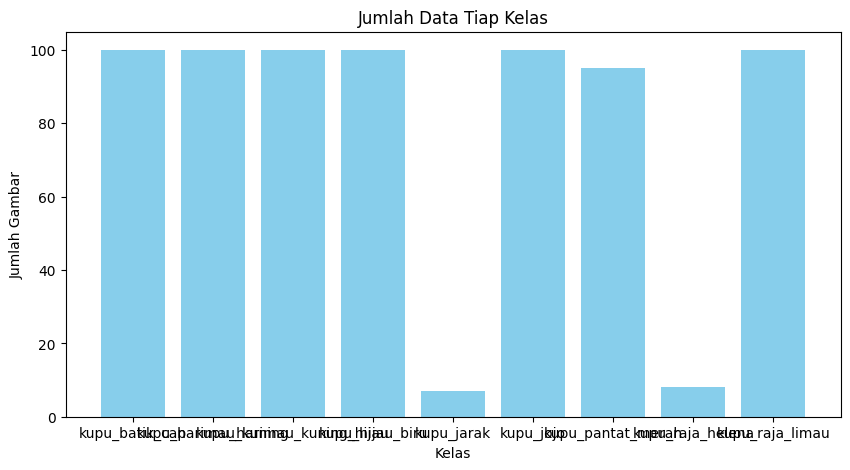

In [9]:
# Inisialisasi variabel class_counts untuk menyimpan jumlah data tiap kelas
class_counts = {class_name: 0 for class_name in class_names}

# Hitung jumlah data tiap kelas
for images, labels in dataset:
    for label in labels:
        class_counts[class_names[label]] += 1

# Tampilkan jumlah data tiap kelas
print("\nJumlah data tiap kelas:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} gambar")

# Visualisasi jumlah data tiap kelas menggunakan chart bar
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Jumlah Data Tiap Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.show()

**Tampilkan gambar di tiap kelas**

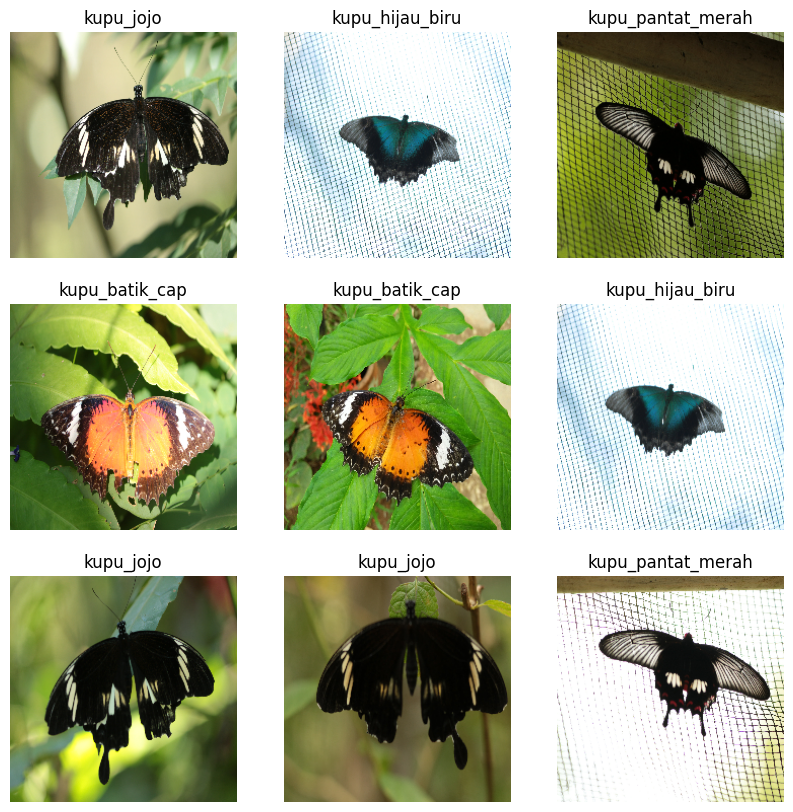

In [10]:
# visualisasi data tiap kelas dataset
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

### **Preprocessing**

**Split data menjadi 3 pembagian**

In [11]:
# Pembagian data training -> 70%
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,  # 70% untuk training
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Pembagian data validasi dan testing -> 30%
val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Pembagian data validasi  -> 15%
val_ds = val_test_ds.take(len(val_test_ds) // 2)

# Pembagian data testing -> 15%
test_ds = val_test_ds.skip(len(val_test_ds) // 2)

Found 710 files belonging to 9 classes.
Using 497 files for training.
Found 710 files belonging to 9 classes.
Using 213 files for validation.


**Hitung jumlah gambar di masing-masing proporsi data**

In [12]:
num_train_files = sum([len(labels) for images, labels in train_ds])
num_val_files = sum([len(labels) for images, labels in val_ds])
num_test_files = sum([len(labels) for images, labels in test_ds])

print(f"Jumlah Data di Dataset Training: {num_train_files}")
print(f"Jumlah Data di Dataset Validasi: {num_val_files}")
print(f"Jumlah Data di Dataset Testing: {num_test_files}")

Jumlah Data di Dataset Training: 497
Jumlah Data di Dataset Validasi: 96
Jumlah Data di Dataset Testing: 117


**Augmentasi dan normalisasi data menggunakan ImageDataGenerator**

In [13]:
# Augmentasi dan Normalisasi data training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Normalisasi data validasi
val_datagen = ImageDataGenerator(rescale=1./255)

# Normalisasi data testing
test_datagen = ImageDataGenerator(rescale=1./255)

### **Pembuatan Model**

#### **Arsitektur VGG16-SVM**

##### **1**

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
Validation Accuracy: 75.00%
Test Accuracy: 76.07%
Classification Report:
                           precision    recall  f1-s

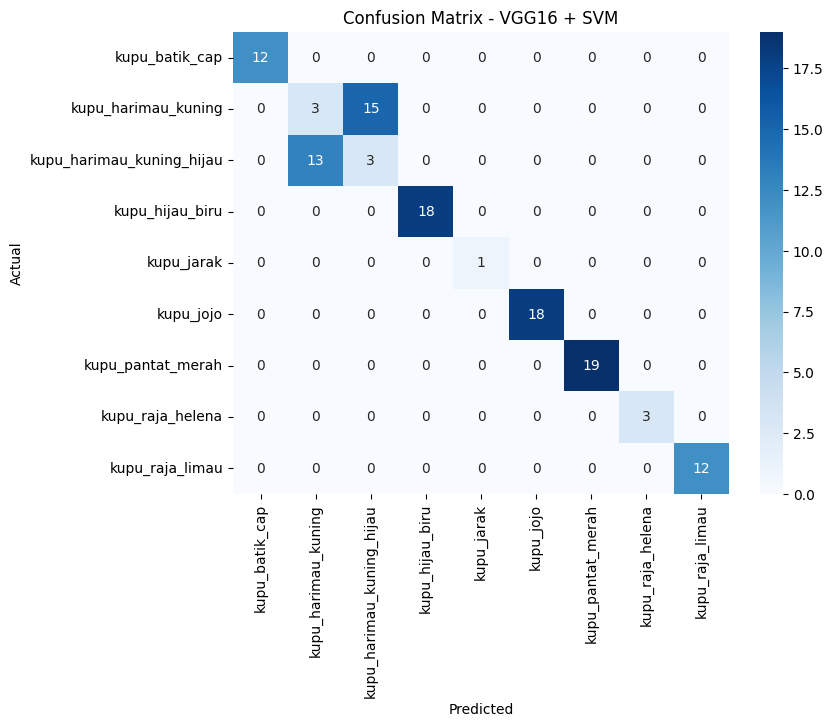

In [ ]:
# Fungsi untuk mengukur waktu komputasi dan penggunaan memori
start_time = time.time()
tracemalloc.start()

# Menerapkan arsitektur VGG16 tanpa lapisan atas (Fully Connected Layer)
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze semua layer pada model VGG16 untuk mempertahankan bobot yang sudah dilatih
for layer in base_model.layers:
    layer.trainable = False

# Tambahkan lapisan Flatten setelah VGG16 untuk menyiapkan fitur untuk SVM
x = base_model.output
x = Flatten()(x)

# Buat model untuk ekstraksi fitur
feature_extractor = Model(inputs=base_model.input, outputs=x)

# Menampilkan summary dari model feature_extractor
feature_extractor.summary()

# Ekstraksi fitur dari data training
train_features = []
train_labels = []

for images, labels in train_ds:
    features = feature_extractor.predict(images)
    train_features.append(features)
    train_labels.append(labels)

train_features = np.vstack(train_features)
train_labels = np.hstack(train_labels)

# Ekstraksi fitur dari data validasi
val_features = []
val_labels = []

for images, labels in val_ds:
    features = feature_extractor.predict(images)
    val_features.append(features)
    val_labels.append(labels)

val_features = np.vstack(val_features)
val_labels = np.hstack(val_labels)

# Ekstraksi fitur dari data testing
test_features = []
test_labels = []

for images, labels in test_ds:
    features = feature_extractor.predict(images)
    test_features.append(features)
    test_labels.append(labels)

test_features = np.vstack(test_features)
test_labels = np.hstack(test_labels)

# Inisialisasi dan latih model SVM
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(train_features, train_labels)

# Evaluasi model SVM pada data validasi
val_predictions = svm_model.predict(val_features)
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Evaluasi model SVM pada data testing
test_predictions = svm_model.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Menampilkan laporan klasifikasi dan confusion matrix
print("Classification Report:")
print(classification_report(test_labels, test_predictions, target_names=class_names))

cm = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(cm)

# Hitung dan tampilkan waktu komputasi dan penggunaan memori
end_time = time.time()
elapsed_time = end_time - start_time
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print(f"Current Memory Usage: {current / 10**6:.2f} MB")
print(f"Peak Memory Usage: {peak / 10**6:.2f} MB")

# Menampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - VGG16 + SVM')
plt.show()

#### **Arsitektur ResNet50-SVM**

##### **1**

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Validation Accuracy: 73.96%
Test Accuracy: 78.63%
Classification Report:
                           precision    recall  f1-

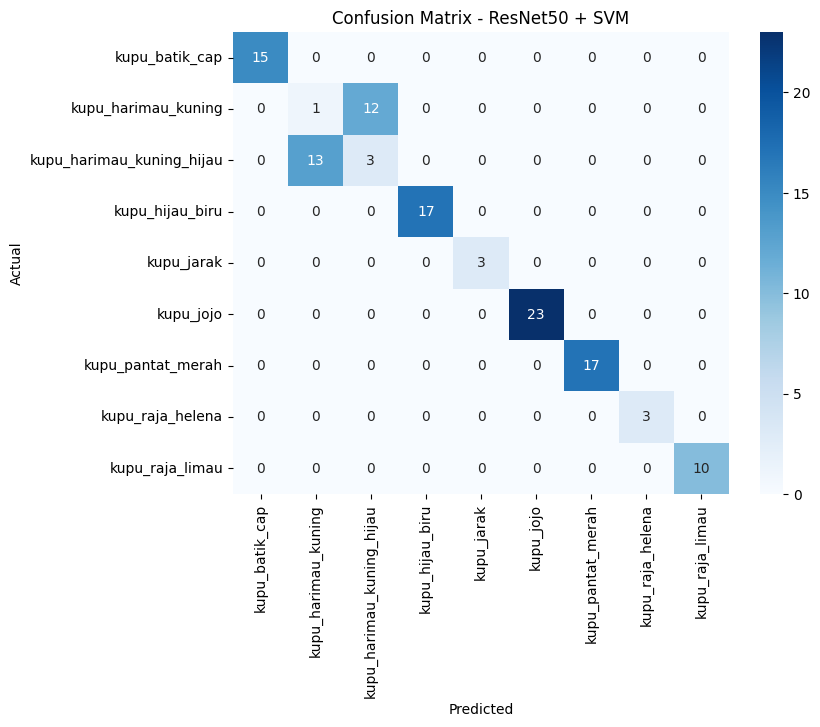

In [ ]:
# Fungsi untuk mengukur waktu komputasi dan penggunaan memori
start_time = time.time()
tracemalloc.start()

# Menerapkan arsitektur ResNet50 tanpa lapisan atas (Fully Connected Layer)
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze semua layer pada model ResNet50 untuk mempertahankan bobot yang sudah dilatih
for layer in base_model.layers:
    layer.trainable = False

# Tambahkan lapisan Flatten setelah ResNet50 untuk menyiapkan fitur untuk SVM
x = base_model.output
x = Flatten()(x)

# Buat model untuk ekstraksi fitur
feature_extractor = Model(inputs=base_model.input, outputs=x)

# Menampilkan summary dari model feature_extractor
feature_extractor.summary()

# Ekstraksi fitur dari data training
train_features = []
train_labels = []

for images, labels in train_ds:
    features = feature_extractor.predict(images)
    train_features.append(features)
    train_labels.append(labels)

train_features = np.vstack(train_features)
train_labels = np.hstack(train_labels)

# Ekstraksi fitur dari data validasi
val_features = []
val_labels = []

for images, labels in val_ds:
    features = feature_extractor.predict(images)
    val_features.append(features)
    val_labels.append(labels)

val_features = np.vstack(val_features)
val_labels = np.hstack(val_labels)

# Ekstraksi fitur dari data testing
test_features = []
test_labels = []

for images, labels in test_ds:
    features = feature_extractor.predict(images)
    test_features.append(features)
    test_labels.append(labels)

test_features = np.vstack(test_features)
test_labels = np.hstack(test_labels)

# Inisialisasi dan latih model SVM
svm_model = SVC(kernel='linear', C=1.0)

svm_model.fit(train_features, train_labels)

# Evaluasi model SVM pada data validasi
val_predictions = svm_model.predict(val_features)
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Evaluasi model SVM pada data testing
test_predictions = svm_model.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Menampilkan laporan klasifikasi dan confusion matrix
print("Classification Report:")
print(classification_report(test_labels, test_predictions, target_names=class_names))

cm = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(cm)

# Hitung dan tampilkan waktu komputasi dan penggunaan memori
end_time = time.time()
elapsed_time = end_time - start_time
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print(f"Current Memory Usage: {current / 10**6:.2f} MB")
print(f"Peak Memory Usage: {peak / 10**6:.2f} MB")

# Menampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - ResNet50 + SVM')
plt.show()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Validation Accuracy: 75.00%
Test Accuracy: 76.07%
Classification Report:
                           precision    recall  f1-score   support

           

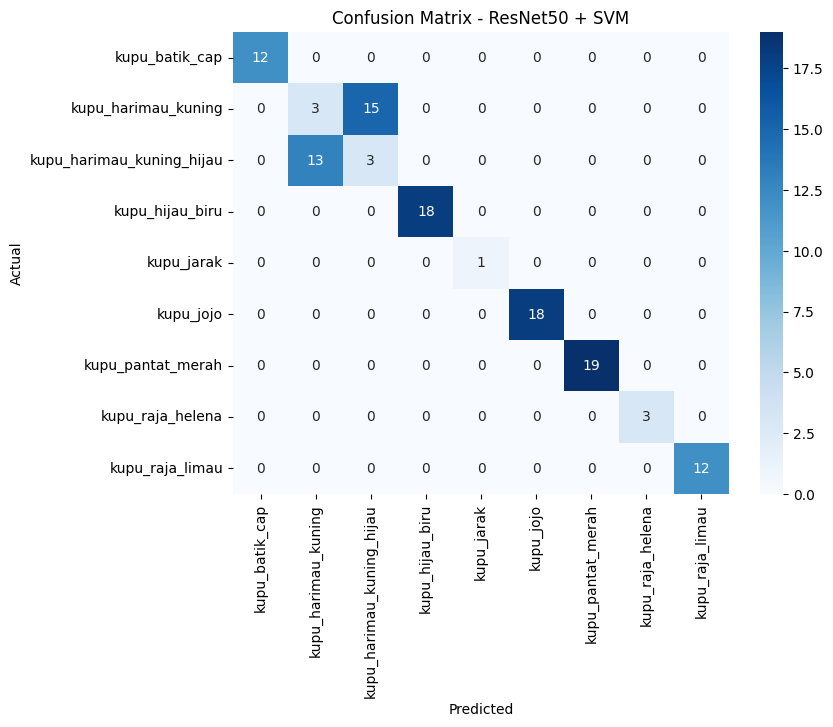

In [ ]:
# Fungsi untuk mengukur waktu komputasi dan penggunaan memori
start_time = time.time()
tracemalloc.start()

# Menerapkan arsitektur ResNet50 tanpa lapisan atas (Fully Connected Layer)
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze semua layer pada model ResNet50 untuk mempertahankan bobot yang sudah dilatih
for layer in base_model.layers:
    layer.trainable = False

# Tambahkan lapisan Flatten setelah ResNet50 untuk menyiapkan fitur untuk SVM
x = base_model.output
x = Flatten()(x)

# Buat model untuk ekstraksi fitur
feature_extractor = Model(inputs=base_model.input, outputs=x)

# Menampilkan summary dari model feature_extractor
feature_extractor.summary()

# Ekstraksi fitur dari data training
train_features = []
train_labels = []

for images, labels in train_ds:
    features = feature_extractor.predict(images)
    train_features.append(features)
    train_labels.append(labels)

train_features = np.vstack(train_features)
train_labels = np.hstack(train_labels)

# Ekstraksi fitur dari data validasi
val_features = []
val_labels = []

for images, labels in val_ds:
    features = feature_extractor.predict(images)
    val_features.append(features)
    val_labels.append(labels)

val_features = np.vstack(val_features)
val_labels = np.hstack(val_labels)

# Ekstraksi fitur dari data testing
test_features = []
test_labels = []

for images, labels in test_ds:
    features = feature_extractor.predict(images)
    test_features.append(features)
    test_labels.append(labels)

test_features = np.vstack(test_features)
test_labels = np.hstack(test_labels)

# Simpan fitur dan label
np.save('/content/drive/MyDrive/DeepL/hasil/ResNet50-TrainFeature.npy', train_features)
np.save('/content/drive/MyDrive/DeepL/hasil/ResNet50-TestFeature.npy', test_features)
np.save('/content/drive/MyDrive/DeepL/hasil/ResNet50-ValFeature.npy', val_features)
np.save('/content/drive/MyDrive/DeepL/hasil/ResNet50-TrainLabel.npy', train_labels)
np.save('/content/drive/MyDrive/DeepL/hasil/ResNet50-TestLabel.npy', test_labels)
np.save('/content/drive/MyDrive/DeepL/hasil/ResNet50-ValLabel.npy', val_labels)

# Inisialisasi dan latih model SVM
svm_model = SVC(kernel='linear', C=1.0)

svm_model.fit(train_features, train_labels)

# Evaluasi model SVM pada data validasi
val_predictions = svm_model.predict(val_features)
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Evaluasi model SVM pada data testing
test_predictions = svm_model.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Menampilkan laporan klasifikasi dan confusion matrix
print("Classification Report:")
print(classification_report(test_labels, test_predictions, target_names=class_names))

cm = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(cm)

# Menyimpan model SVM
save_model_checkpoint(svm_model, model_name="ResNet50+SVM", test_accuracy=test_accuracy)

# Hitung dan tampilkan waktu komputasi dan penggunaan memori
end_time = time.time()
elapsed_time = end_time - start_time
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print(f"Current Memory Usage: {current / 10**6:.2f} MB")
print(f"Peak Memory Usage: {peak / 10**6:.2f} MB")

# Menampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - ResNet50 + SVM')
plt.show()

## **Hyperparameter Tuning**

**Kernel Linear**

In [ ]:
# Load fitur dan label yang telah disimpan
train_features = np.load('/content/drive/MyDrive/DeepL/hasil/ResNet50-TrainFeature.npy')
test_features = np.load('/content/drive/MyDrive/DeepL/hasil/ResNet50-TestFeature.npy')
val_features = np.load('/content/drive/MyDrive/DeepL/hasil/ResNet50-ValFeature.npy')
train_labels = np.load('/content/drive/MyDrive/DeepL/hasil/ResNet50-TrainLabel.npy')
test_labels = np.load('/content/drive/MyDrive/DeepL/hasil/ResNet50-TestLabel.npy')
val_labels = np.load('/content/drive/MyDrive/DeepL/hasil/ResNet50-ValLabel.npy')

# Mendefinisikan parameter yang ingin dituning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear'],
}

# Inisialisasi GridSearchCV
grid_search = GridSearchCV(SVC(), param_grid, cv=3, verbose=2, n_jobs=-1)

# Inisialisasi GridSearchCV
grid_search = GridSearchCV(SVC(), param_grid, cv=3, verbose=2, n_jobs=-1)

# Mulai penghitungan waktu tuning
start_time = time.time()

# Lakukan fit pada GridSearchCV
grid_search.fit(train_features, train_labels)

# Akhiri penghitungan waktu tuning
end_time = time.time()
tuning_time = end_time - start_time

# Tampilkan hasil tuning terbaik
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Tampilkan semua hasil cross-validation untuk semua kombinasi parameter dalam bentuk DataFrame
results = pd.DataFrame(grid_search.cv_results_)
results = results[['params', 'mean_test_score']]

# Menyimpan model terbaik yang dihasilkan dari GridSearchCV
best_svm_model = grid_search.best_estimator_
joblib.dump(best_svm_model, '/content/drive/MyDrive/DeepL/hasil/ResNet50+SVM_linear.joblib')

# Evaluasi model SVM terbaik pada data testing
test_predictions = best_svm_model.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy after tuning: {test_accuracy * 100:.2f}%")

# Menampilkan hasil GridSearchCV dalam bentuk DataFrame
print("Grid scores on training set:")
print(results)

# Tampilkan waktu komputasi tuning
print(f"Total waktu komputasi tuning: {tuning_time:.2f} detik")

Fitting 3 folds for each of 7 candidates, totalling 21 fits
Best Parameters: {'C': 1000, 'kernel': 'linear'}
Best Cross-Validation Score: 0.820944383594986
Test Accuracy after tuning: 82.05%
Grid scores on training set:
                             params  mean_test_score
0  {'C': 0.001, 'kernel': 'linear'}         0.800840
1   {'C': 0.01, 'kernel': 'linear'}         0.800840
2    {'C': 0.1, 'kernel': 'linear'}         0.800840
3      {'C': 1, 'kernel': 'linear'}         0.800840
4     {'C': 10, 'kernel': 'linear'}         0.798820
5    {'C': 100, 'kernel': 'linear'}         0.810904
6   {'C': 1000, 'kernel': 'linear'}         0.820944
Total waktu komputasi tuning: 345.45 detik


**Kernel Sigmoid**

In [ ]:
from sklearn.model_selection import GridSearchCV

# Load fitur dan label yang telah disimpan
np.save('/content/drive/MyDrive/DeepL/hasil/ResNet50-TrainFeature.npy', train_features)
np.save('/content/drive/MyDrive/DeepL/hasil/ResNet50-TestFeature.npy', test_features)
np.save('/content/drive/MyDrive/DeepL/hasil/ResNet50-ValFeature.npy', val_features)
np.save('/content/drive/MyDrive/DeepL/hasil/ResNet50-TrainLabel.npy', train_labels)
np.save('/content/drive/MyDrive/DeepL/hasil/ResNet50-TestLabel.npy', test_labels)
np.save('/content/drive/MyDrive/DeepL/hasil/ResNet50-ValLabel.npy', val_labels)

# Mendefinisikan parameter yang ingin dituning
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['sigmoid'],
    'gamma': [0.001, 0.1, 1, 10]
}

# Inisialisasi GridSearchCV
grid_search = GridSearchCV(SVC(), param_grid, cv=3, verbose=2, n_jobs=-1)

# Lakukan fit pada GridSearchCV
grid_search.fit(train_features, train_labels)

# Tampilkan hasil tuning terbaik
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Tampilkan semua hasil cross-validation untuk semua kombinasi parameter
print("Grid scores on training set:")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print(f"{mean:.3f} (+/-{std * 2:.3f}) for {params}")

# Simpan model terbaik yang dihasilkan dari GridSearchCV
best_svm_model = grid_search.best_estimator_
joblib.dump(best_svm_model, '/content/drive/MyDrive/DeepL/hasil/ResNet50+SVM_sigmoid.joblib')

# Evaluasi model SVM terbaik pada data testing
test_predictions = best_svm_model.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy after tuning: {test_accuracy * 100:.2f}%")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'C': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}
Best Cross-Validation Score: 0.1529146890592674
Grid scores on training set:
0.153 (+/-0.005) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.153 (+/-0.005) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.153 (+/-0.005) for {'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}
0.153 (+/-0.005) for {'C': 0.1, 'gamma': 10, 'kernel': 'sigmoid'}
0.153 (+/-0.005) for {'C': 1, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.153 (+/-0.005) for {'C': 1, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.153 (+/-0.005) for {'C': 1, 'gamma': 1, 'kernel': 'sigmoid'}
0.153 (+/-0.005) for {'C': 1, 'gamma': 10, 'kernel': 'sigmoid'}
0.153 (+/-0.005) for {'C': 10, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.153 (+/-0.005) for {'C': 10, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.153 (+/-0.005) for {'C': 10, 'gamma': 1, 'kernel': 'sigmoid'}
0.153 (+/-0.005) for {'C': 10, 'gamma': 10, 'kernel': 'sigmoid'}
0.153 (+

## **Skenario Pengujian**

#### **60:20:20 w/ ResNet50-SVM Kernel Linear; C = 0.1**

In [ ]:
# Pembagian data training -> 60%
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.4,  # 60% untuk training
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Pembagian data validasi dan testing -> 40%
val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.4,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Pembagian data validasi  -> 20%
val_ds = val_test_ds.take(len(val_test_ds) // 2)

# Pembagian data testing -> 20%
test_ds = val_test_ds.skip(len(val_test_ds) // 2)

# Augmentasi dan Normalisasi data training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Normalisasi data validasi
val_datagen = ImageDataGenerator(rescale=1./255)

# Normalisasi data testing
test_datagen = ImageDataGenerator(rescale=1./255)

Found 710 files belonging to 9 classes.
Using 426 files for training.
Found 710 files belonging to 9 classes.
Using 284 files for validation.


##### **1**

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Validation Accuracy: 78.91%
Test Accuracy: 76.92%
Classification Report:
                           precision    recall  f1-score   support

     

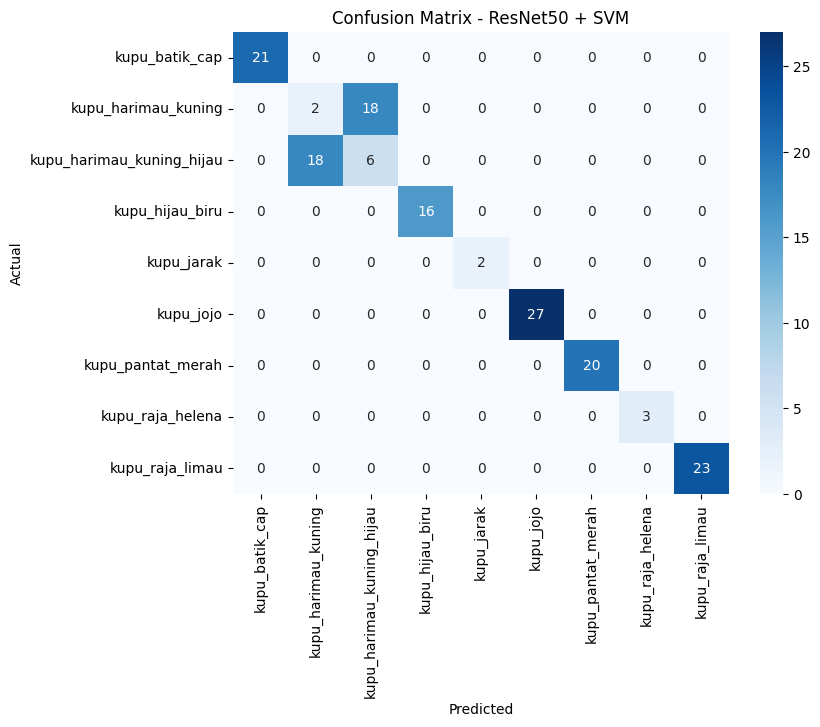

In [ ]:
# Fungsi untuk mengukur waktu komputasi dan penggunaan memori
start_time = time.time()
tracemalloc.start()

# Menerapkan arsitektur ResNet50 tanpa lapisan atas (Fully Connected Layer)
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze semua layer pada model ResNet50 untuk mempertahankan bobot yang sudah dilatih
for layer in base_model.layers:
    layer.trainable = False

# Tambahkan lapisan Flatten setelah ResNet50 untuk menyiapkan fitur untuk SVM
x = base_model.output
x = Flatten()(x)

# Buat model untuk ekstraksi fitur
feature_extractor = Model(inputs=base_model.input, outputs=x)

# Menampilkan summary dari model feature_extractor
feature_extractor.summary()

# Ekstraksi fitur dari data training
train_features = []
train_labels = []

for images, labels in train_ds:
    features = feature_extractor.predict(images)
    train_features.append(features)
    train_labels.append(labels)

train_features = np.vstack(train_features)
train_labels = np.hstack(train_labels)

# Ekstraksi fitur dari data validasi
val_features = []
val_labels = []

for images, labels in val_ds:
    features = feature_extractor.predict(images)
    val_features.append(features)
    val_labels.append(labels)

val_features = np.vstack(val_features)
val_labels = np.hstack(val_labels)

# Ekstraksi fitur dari data testing
test_features = []
test_labels = []

for images, labels in test_ds:
    features = feature_extractor.predict(images)
    test_features.append(features)
    test_labels.append(labels)

test_features = np.vstack(test_features)
test_labels = np.hstack(test_labels)

# Inisialisasi dan latih model SVM
svm_model = SVC(kernel='linear', C=0.1)

svm_model.fit(train_features, train_labels)

# Evaluasi model SVM pada data validasi
val_predictions = svm_model.predict(val_features)
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Evaluasi model SVM pada data testing
test_predictions = svm_model.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Menampilkan laporan klasifikasi dan confusion matrix
print("Classification Report:")
print(classification_report(test_labels, test_predictions, target_names=class_names))

cm = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(cm)

# Hitung dan tampilkan waktu komputasi dan penggunaan memori
end_time = time.time()
elapsed_time = end_time - start_time
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print(f"Current Memory Usage: {current / 10**6:.2f} MB")
print(f"Peak Memory Usage: {peak / 10**6:.2f} MB")

# Menampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - ResNet50 + SVM')
plt.show()

#### **70:15:15 w/ ResNet50-SVM Kernel Linear; C = 0.1**

In [ ]:
# Pembagian data training -> 70%
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,  # 70% untuk training
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Pembagian data validasi dan testing -> 30%
val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Pembagian data validasi  -> 15%
val_ds = val_test_ds.take(len(val_test_ds) // 2)

# Pembagian data testing -> 15%
test_ds = val_test_ds.skip(len(val_test_ds) // 2)

# Augmentasi dan Normalisasi data training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Normalisasi data validasi
val_datagen = ImageDataGenerator(rescale=1./255)

# Normalisasi data testing
test_datagen = ImageDataGenerator(rescale=1./255)

Found 710 files belonging to 9 classes.
Using 497 files for training.
Found 710 files belonging to 9 classes.
Using 213 files for validation.


##### **1**

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Validation Accuracy: 84.38%
Test Accuracy: 78.63%
Classification Report:
                           precision    recall  f1-score   support

           ku

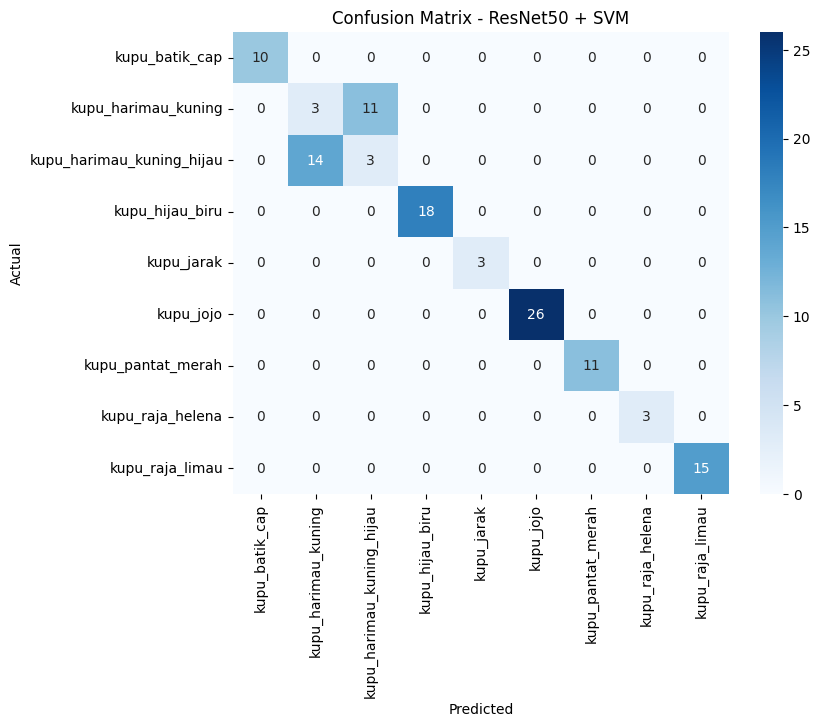

In [ ]:
# Fungsi untuk mengukur waktu komputasi dan penggunaan memori
start_time = time.time()
tracemalloc.start()

# Menerapkan arsitektur ResNet50 tanpa lapisan atas (Fully Connected Layer)
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze semua layer pada model ResNet50 untuk mempertahankan bobot yang sudah dilatih
for layer in base_model.layers:
    layer.trainable = False

# Tambahkan lapisan Flatten setelah ResNet50 untuk menyiapkan fitur untuk SVM
x = base_model.output
x = Flatten()(x)

# Buat model untuk ekstraksi fitur
feature_extractor = Model(inputs=base_model.input, outputs=x)

# Menampilkan summary dari model feature_extractor
feature_extractor.summary()

# Ekstraksi fitur dari data training
train_features = []
train_labels = []

for images, labels in train_ds:
    features = feature_extractor.predict(images)
    train_features.append(features)
    train_labels.append(labels)

train_features = np.vstack(train_features)
train_labels = np.hstack(train_labels)

# Ekstraksi fitur dari data validasi
val_features = []
val_labels = []

for images, labels in val_ds:
    features = feature_extractor.predict(images)
    val_features.append(features)
    val_labels.append(labels)

val_features = np.vstack(val_features)
val_labels = np.hstack(val_labels)

# Ekstraksi fitur dari data testing
test_features = []
test_labels = []

for images, labels in test_ds:
    features = feature_extractor.predict(images)
    test_features.append(features)
    test_labels.append(labels)

test_features = np.vstack(test_features)
test_labels = np.hstack(test_labels)

# Inisialisasi dan latih model SVM
svm_model = SVC(kernel='linear', C=0.1)

svm_model.fit(train_features, train_labels)

# Evaluasi model SVM pada data validasi
val_predictions = svm_model.predict(val_features)
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Evaluasi model SVM pada data testing
test_predictions = svm_model.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Menampilkan laporan klasifikasi dan confusion matrix
print("Classification Report:")
print(classification_report(test_labels, test_predictions, target_names=class_names))

cm = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(cm)

# Hitung dan tampilkan waktu komputasi dan penggunaan memori
end_time = time.time()
elapsed_time = end_time - start_time
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print(f"Current Memory Usage: {current / 10**6:.2f} MB")
print(f"Peak Memory Usage: {peak / 10**6:.2f} MB")

# Menampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - ResNet50 + SVM')
plt.show()

## **Evaluasi Model**

### **ResNet50 Tunggal**

##### **1**

In [16]:
# Pembagian data training -> 80%
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 80% untuk training
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Pembagian data validasi dan testing -> 20%
val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Pembagian data validasi  -> 10%
val_ds = val_test_ds.take(len(val_test_ds) // 2)

# Pembagian data testing -> 10%
test_ds = val_test_ds.skip(len(val_test_ds) // 2)

# Augmentasi dan Normalisasi data training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Normalisasi data validasi
val_datagen = ImageDataGenerator(rescale=1./255)

# Normalisasi data testing
test_datagen = ImageDataGenerator(rescale=1./255)

Found 710 files belonging to 9 classes.
Using 568 files for training.
Found 710 files belonging to 9 classes.
Using 142 files for validation.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 49,815,689 (190.03 MB)

 Trainable params: 26,027,273 (99.29 MB)

 Non-trainable params: 23,788,416 (90.75 MB)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.4476 - loss: 1.9256 - val_accuracy: 0.8438 - val_loss: 0.3248
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.7583 - loss: 0.9637 - val_accuracy: 0.8906 - val_loss: 0.2319
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.7908 - loss: 0.8759 - val_accuracy: 0.7969 - val_loss: 0.5847
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.8307 - loss: 0.7292 - val_accuracy: 0.7812 - val_loss: 0.5684
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.7971 - loss: 0.9655 - val_accuracy: 0.8438 - val_loss: 0.3014
Training Time: 358.92 seconds
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.9062 - loss: 0.1994
Validation Accuracy: 87.50%
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8037 - loss: 0.4721
Test Accuracy: 79.49%


2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Confusion Matrix
[[13  0  0  0  0  0  0  0  0]
 [ 0  2  6  0  0  0  0  0  0]
 [ 0  5  4  0  0  0  0  0  0]
 [ 0  0  0 14  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0 12  0  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  5]]
Classification Report
                           precision    recall  f1-score   support

           kupu_batik_cap       1.00      1.00      1.00        13
      kupu_harimau_kuning       0.29      0.25      0.27         8
kupu_harimau_kuning_hijau       0.40      0.44      0.42         9
          kupu_hijau_biru       1.00      1.00      1.00        14
               kupu_jarak       1.00      1.00      1.00         1
                kupu_jojo       1.00      1.00      1.00        12
        kupu_pantat_merah       1.00      1.00      1.00        14
      

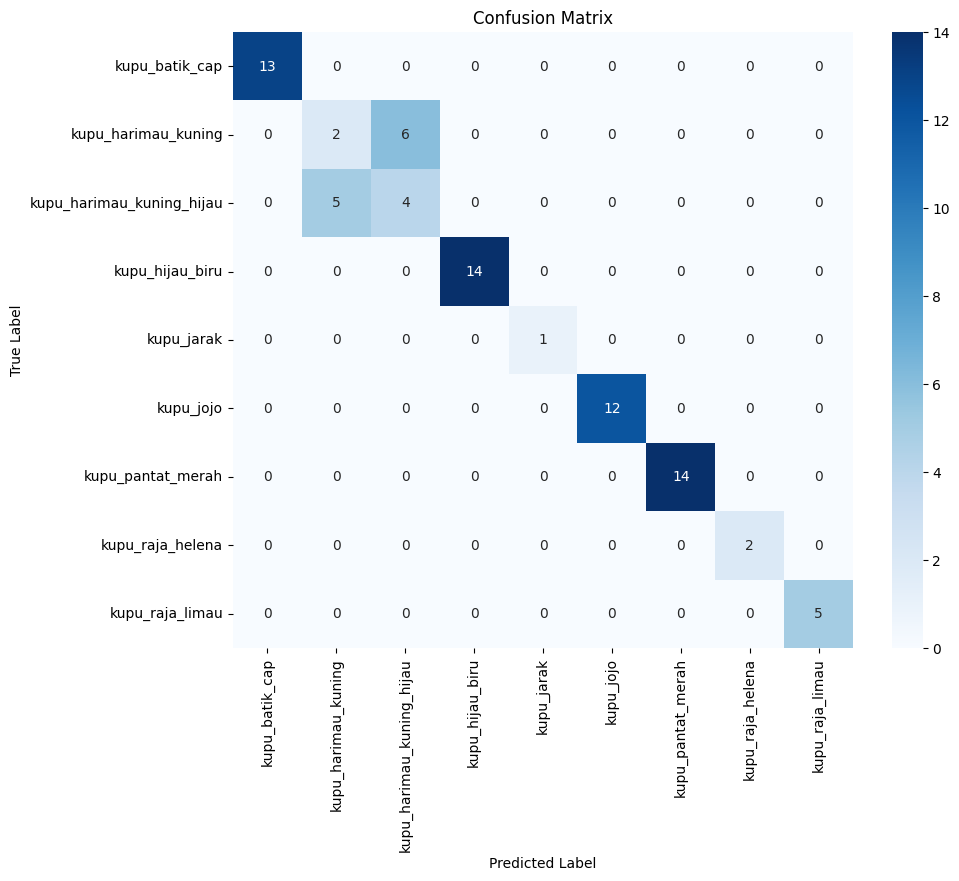

In [18]:
learning_rate = 0.0001

# Menerapkan arsitektur ResNet50 tanpa lapisan atas (Fully Connected Layer)
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

# Tambahkan lapisan di atas model ResNet50
x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(class_names), activation='softmax')(x)

# Buat model final
model = Model(inputs=base_model.input, outputs=x)

# Menampilkan summary dari model
model.summary()

# Compile Model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callback Early Stopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               restore_best_weights=True)

# Mengukur waktu komputasi
start_time = time.time()

# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1,
    callbacks=[early_stopping]
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

# Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Evaluasi model pada data testing
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Prediksi pada data testing
Y_pred = model.predict(test_ds)
y_pred = np.argmax(Y_pred, axis=1)

# Mengambil data testing dari test_ds
def get_labels_and_predictions(ds):
    y_true = []
    y_pred = []
    for images, labels in ds:
        predictions = model.predict(images, batch_size=batch_size)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))
    return np.array(y_true), np.array(y_pred)

# Dapatkan label dan prediksi dari data testing
y_true, y_pred = get_labels_and_predictions(test_ds)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix')
print(conf_matrix)

# Classification Report
# Pastikan class_names sesuai dengan jumlah kelas yang ada di y_true
unique_classes = np.unique(y_true)
adjusted_class_names = [class_names[i] for i in unique_classes]

print('Classification Report')
print(classification_report(y_true, y_pred, target_names=adjusted_class_names))

# Plot Confusion Matrix menggunakan Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=adjusted_class_names, yticklabels=adjusted_class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### **VGG16 Tunggal**

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 25088)               │         100,352 │
│ (BatchNormalization)                 │                             │              

 Total params: 21,374,025 (81.54 MB)

 Trainable params: 6,609,161 (25.21 MB)

 Non-trainable params: 14,764,864 (56.32 MB)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 538s 33s/step - accuracy: 0.2805 - loss: 2.2189 - val_accuracy: 0.7292 - val_loss: 0.4581
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 503s 29s/step - accuracy: 0.6977 - loss: 0.7761 - val_accuracy: 0.7917 - val_loss: 0.4044
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 482s 30s/step - accuracy: 0.8268 - loss: 0.4758 - val_accuracy: 0.7604 - val_loss: 0.4914
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 493s 29s/step - accuracy: 0.8154 - loss: 0.4763 - val_accuracy: 0.8229 - val_loss: 0.3884
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 553s 33s/step - accuracy: 0.8434 - loss: 0.3785 - val_accuracy: 0.7292 - val_loss: 0.4525
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 559s 33s/step - accuracy: 0.8578 - loss: 0.3413 - val_accuracy: 0.7812 - val_loss: 0.5197
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 507s 29s/step - accuracy: 0.8822 - loss: 0.2944 - val_accuracy: 0.8021 - val_loss: 0.4494
Training Time: 3634.82 seconds
3/3 ━━━━━━━━━━━━━━━━━━━━ 91s 25s/step - accuracy: 0.7604 - loss: 0.5126
V

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


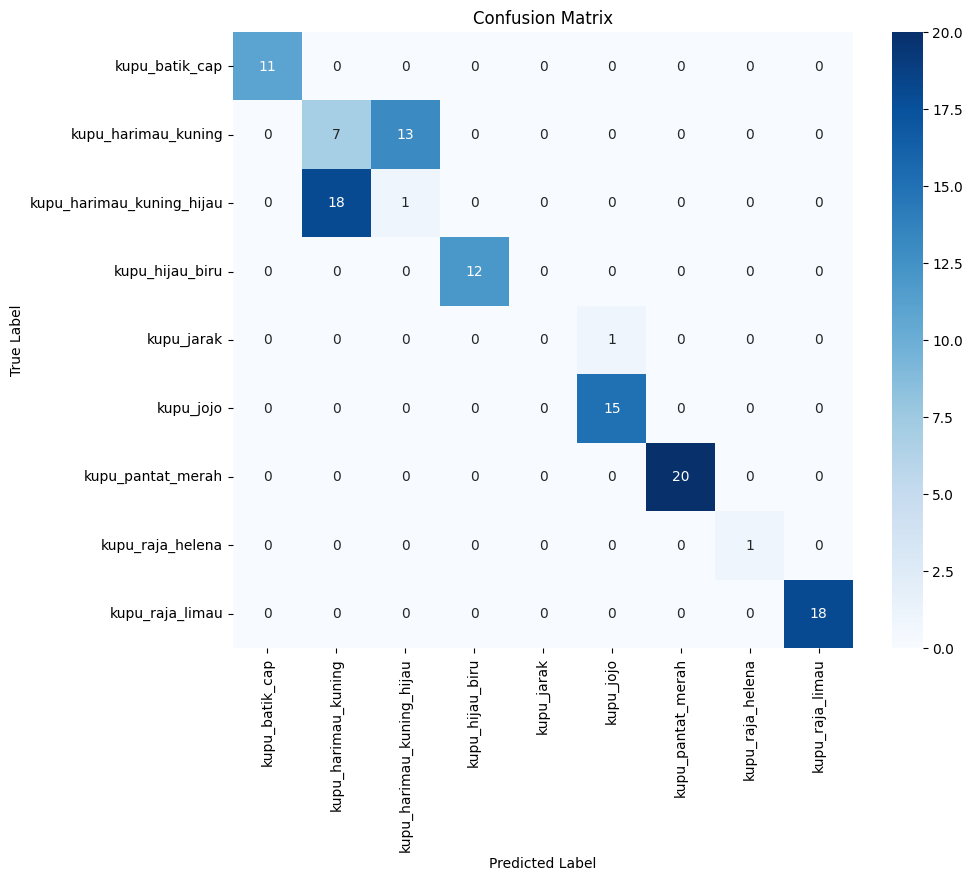

In [ ]:
from tensorflow.keras.applications import VGG16 # Import the VGG16 class
learning_rate = 0.0001

# Menerapkan arsitektur VGG16 tanpa lapisan atas (Fully Connected Layer)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

# Tambahkan lapisan di atas model VGG16
x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(class_names), activation='softmax')(x)

# Buat model final
model = Model(inputs=base_model.input, outputs=x)

# Menampilkan summary dari model
model.summary()

# Compile model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callback Early Stopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               restore_best_weights=True)

# Mengukur waktu komputasi
start_time = time.time()

# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1,
    callbacks=[early_stopping]
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

# Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Evaluasi model pada data testing
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Prediksi pada data testing
Y_pred = model.predict(test_ds)
y_pred = np.argmax(Y_pred, axis=1)

# Mengambil data testing dari test_ds
def get_labels_and_predictions(ds):
    y_true = []
    y_pred = []
    for images, labels in ds:
        predictions = model.predict(images, batch_size=batch_size)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))
    return np.array(y_true), np.array(y_pred)

# Dapatkan label dan prediksi dari data testing
y_true, y_pred = get_labels_and_predictions(test_ds)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix')
print(conf_matrix)

# Classification Report
target_names = class_names
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=target_names))

# Plot Confusion Matrix menggunakan Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


### **SVM TUNGGAL**

In [14]:
# Pembagian data training -> 80%
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 80% untuk training
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Pembagian data validasi dan testing -> 20%
val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Pembagian data validasi  -> 10%
val_ds = val_test_ds.take(len(val_test_ds) // 2)

# Pembagian data testing -> 10%
test_ds = val_test_ds.skip(len(val_test_ds) // 2)

# Augmentasi dan Normalisasi data training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Normalisasi data validasi
val_datagen = ImageDataGenerator(rescale=1./255)

# Normalisasi data testing
test_datagen = ImageDataGenerator(rescale=1./255)

Found 710 files belonging to 9 classes.
Using 568 files for training.
Found 710 files belonging to 9 classes.
Using 142 files for validation.


##### **1**

Training Time: 46.79 seconds
Validation Accuracy: 79.69%
Validation Time: 7.64 seconds
Test Accuracy: 74.36%
Testing Time: 3.94 seconds
Classification Report:
                           precision    recall  f1-score   support

           kupu_batik_cap       1.00      0.86      0.92        14
      kupu_harimau_kuning       0.15      0.22      0.18         9
kupu_harimau_kuning_hijau       0.10      0.08      0.09        12
          kupu_hijau_biru       1.00      1.00      1.00        11
               kupu_jarak       1.00      1.00      1.00         1
                kupu_jojo       1.00      1.00      1.00        10
        kupu_pantat_merah       1.00      1.00      1.00        10
         kupu_raja_helena       1.00      1.00      1.00         1
          kupu_raja_limau       1.00      1.00      1.00        10

                 accuracy                           0.74        78
                macro avg       0.81      0.80      0.80        78
             weighted avg       0.7

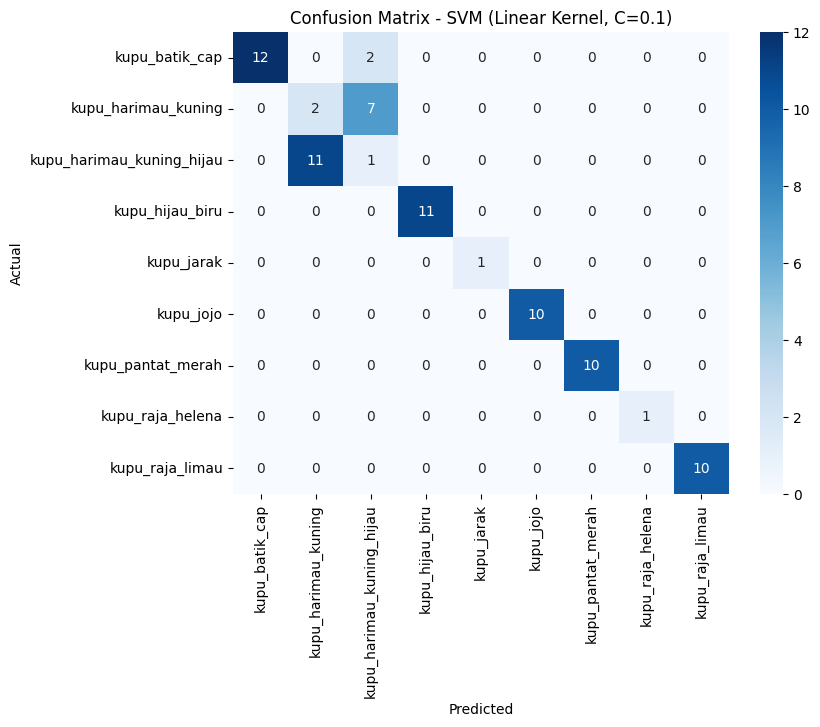

In [15]:
# Fungsi untuk ekstraksi fitur dari dataset
def extract_features(dataset):
    features = []
    labels = []
    for images, labels_batch in dataset:
        # Langsung flatten images karena augmentasi dan normalisasi sudah dilakukan
        features.append(images.numpy().reshape(images.shape[0], -1))
        labels.append(labels_batch.numpy())

    features = np.vstack(features)
    labels = np.hstack(labels)
    return features, labels

# Menggunakan fungsi untuk mengekstrak fitur dan label dari dataset
train_features, train_labels = extract_features(train_ds)
val_features, val_labels = extract_features(val_ds)
test_features, test_labels = extract_features(test_ds)

# Inisialisasi model SVM dengan kernel linear dan C=0.1
svm_model = SVC(kernel='linear', C=0.1)

# Menghitung waktu komputasi untuk pelatihan model
start_time = time.time()

# Melatih model SVM dengan data pelatihan
svm_model.fit(train_features, train_labels)

# Menghitung total waktu pelatihan
training_time = time.time() - start_time
print(f"Training Time: {training_time:.2f} seconds")

# Evaluasi model SVM pada data validasi
start_time = time.time()

val_predictions = svm_model.predict(val_features)
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Menghitung waktu komputasi untuk evaluasi pada data validasi
validation_time = time.time() - start_time
print(f"Validation Time: {validation_time:.2f} seconds")

# Evaluasi model SVM pada data testing
start_time = time.time()

test_predictions = svm_model.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Menghitung waktu komputasi untuk evaluasi pada data testing
testing_time = time.time() - start_time
print(f"Testing Time: {testing_time:.2f} seconds")

# Menampilkan laporan klasifikasi
print("Classification Report:")
print(classification_report(test_labels, test_predictions, target_names=class_names))

# Menyusun confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(cm)

# Menampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM (Linear Kernel, C=0.1)')
plt.show()